<a href="https://colab.research.google.com/github/varakala-vasanth/-Bank-System/blob/main/xss_project_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔒 Web Vulnerability ML — XSS Detector

This notebook implements a **clean, starter ML pipeline** for detecting **Cross‑Site Scripting (XSS)** payloads.

It expands the baseline with:
- **Dataset & Threat Model** documentation
- Rich evaluation: confusion matrix, PR/ROC, calibration, learning curve
- **Precision@K** triage metrics
- **Explainability** (optional SHAP; falls back gracefully)
- **Robustness tests** (simple obfuscations/encodings)
- **Artifact saving** and auto‑generated **Markdown report**
- Optional **Flask** scoring demo (commented)



## 0) Dataset & Threat Model
**Target**: Website inputs vulnerable to **reflected XSS**.

**Scope**: Classify input *payloads* as *benign (0)* vs *XSS (1)* based on text features.

**Assumptions**:
- Dataset columns: **`Sentence`** (text) and **`Label`** (0/1). The code maps them to canonical `payload`/`label`.
- Labels are ground truth for this exercise; real systems should include scanner/human confirmation.



## 1) Setup paths & dependencies

In [ ]:
from google.colab  import drive
drive.mount('/content/drive')
CSV_PATH = '/content/drive/MyDrive/V_Vasanth/XSS_dataset2.csv'
assert CSV_PATH != '', 'Please set CSV_PATH to your dataset file path.'

RANDOM_STATE = 42
ARTIFACT_DIR = '/content/drive/MyDrive/V_Vasanth/'  # save next to your notebook/dataset folder

import  os
os.makedirs(ARTIFACT_DIR, exist_ok=True)

CSV_PATH


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/V_Vasanth/XSS_dataset2.csv'

## 2) Load & map columns (Sentence/Label → payload/label)

In [ ]:
import pandas as  pd
df_raw = pd.read_csv(CSV_PATH)
print('Shape:',  df_raw.shape)
print('Columns:', df_raw.columns.tolist())

# Drop accidental unnamed index columns
unnamed = [c for c in df_raw.columns if c.lower().startswith('unnamed')]
df = df_raw.drop(columns=unnamed) if unnamed else df_raw.copy()

# Map columns
TEXT_CANDS = ['Sentence','payload','sentence','text','query','Text']
LABEL_CANDS =['Label','label','target','class','Class']

def pick(cands, cols):
    for c in cands:
        if c in cols:
            return c
    raise KeyError(f'Could not find any of {cands} in {cols}')

text_col = pick(TEXT_CANDS, df.columns)
label_col = pick(LABEL_CANDS,  df.columns)

df = df[[text_col, label_col]].rename(columns={text_col:'payload', label_col:'label'})
df['payload'] =  df['payload'].fillna('').astype(str)
df['label'] = df['label'].astype(int)
df.head(3)

Shape: (13686, 3)
Columns: ['Unnamed: 0', 'Sentence', 'Label']


,payload,label
0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,"\t </span> <span class=""reference-text"">Steeri...",0


## 3) Quick EDA (class balance, payload length)

Label counts:
 label
1    7373
0    6313
Name: count, dtype: int64


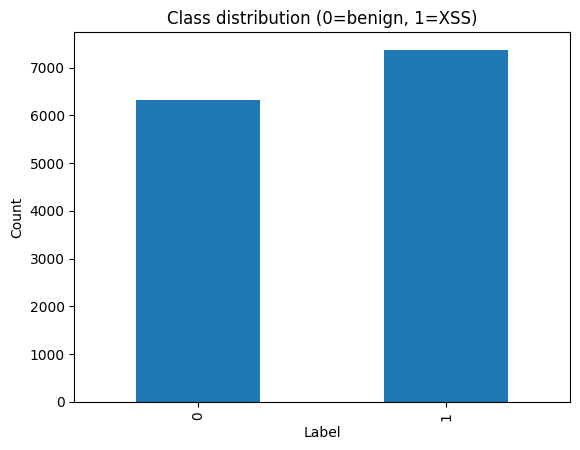

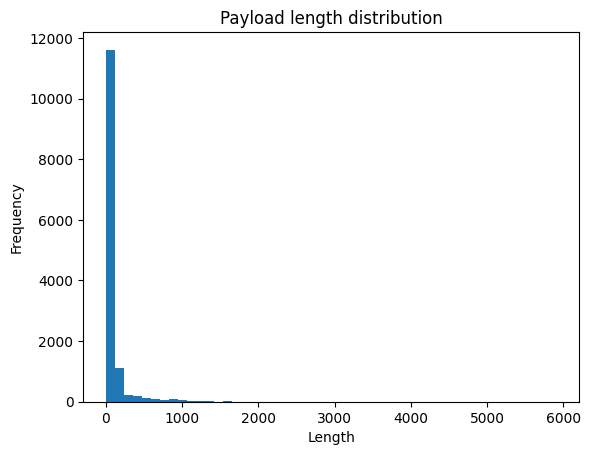

In [ ]:
import  matplotlib.pyplot as plt
print('Label counts:\n', df['label'].value_counts())

plt.figure(); df['label'].value_counts().sort_index().plot(kind='bar');
plt.title('Class distribution (0=benign, 1=XSS)'); plt.xlabel('Label'); plt.ylabel('Count'); plt.show()

plt.figure(); lengths = df['payload'].str.len(); plt.hist(lengths, bins=50);
plt.title('Payload length distribution'); plt.xlabel('Length'); plt.ylabel('Frequency'); plt.show()

## 4) Split & vectorize (TF‑IDF with symbol‑preserving tokenization)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(
    df['payload'], df['label'], test_size=0.2, stratify=df['label'], random_state=RANDOM_STATE
)

vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=20000, token_pattern=r'\S+')
Xtr = vectorizer.fit_transform(X_train)
Xte = vectorizer.transform(X_test)
Xtr.shape, Xte.shape

((10948, 20000), (2738, 20000))

## 5) Train model (Logistic Regression, class‑weighted)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=200, class_weight='balanced', random_state=RANDOM_STATE)
clf.fit(Xtr, y_train)
print('Model trained.')

Model trained.


## 6) Metrics & core plots

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1263
           1       0.96      1.00      0.98      1475

    accuracy                           0.98      2738
   macro avg       0.98      0.98      0.98      2738
weighted avg       0.98      0.98      0.98      2738

PR AUC: 0.9981416975724987
ROC AUC: 0.9978029174550773


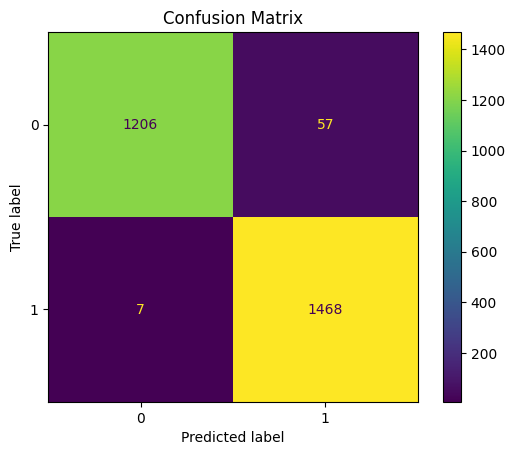

In [ ]:
from sklearn.metrics import classification_report, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import numpy as np
pred = clf.predict(Xte)
probs = clf.predict_proba(Xte)[:,1]
cls_rep = classification_report(y_test, pred, output_dict=True)
print(classification_report(y_test, pred))

prec, rec, _ = precision_recall_curve(y_test, probs)
pr_auc = auc(rec, prec)
print('PR AUC:', pr_auc)

fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
print('ROC AUC:', roc_auc)

ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot();
plt.title('Confusion Matrix'); plt.show()

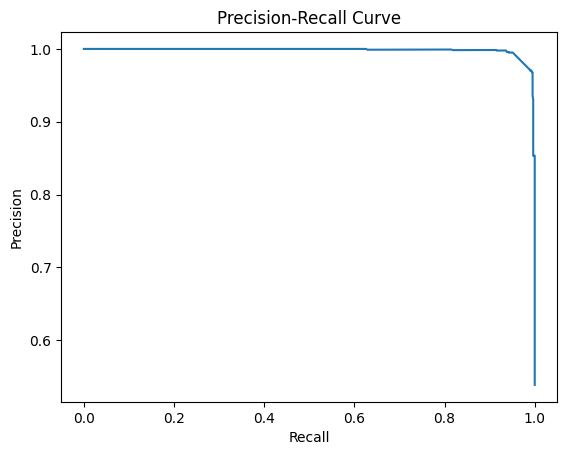

In [ ]:
plt.figure(); plt.plot(rec, prec); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision‑Recall Curve'); plt.show()


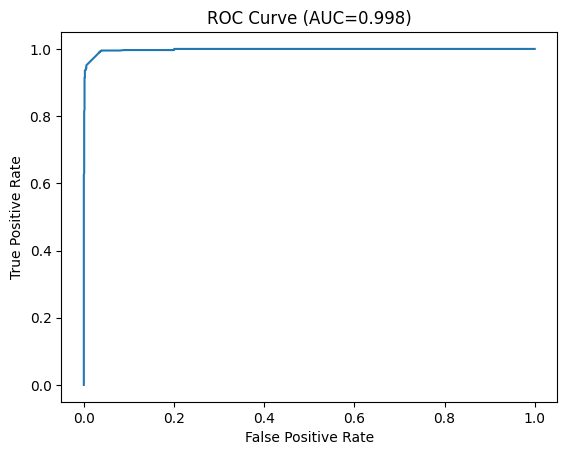

In [ ]:
plt.figure(); plt.plot(fpr, tpr); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title(f'ROC Curve (AUC={roc_auc:.3f})'); plt.show()

## 7) Probability calibration plot
Checks whether predicted probabilities are well‑calibrated.

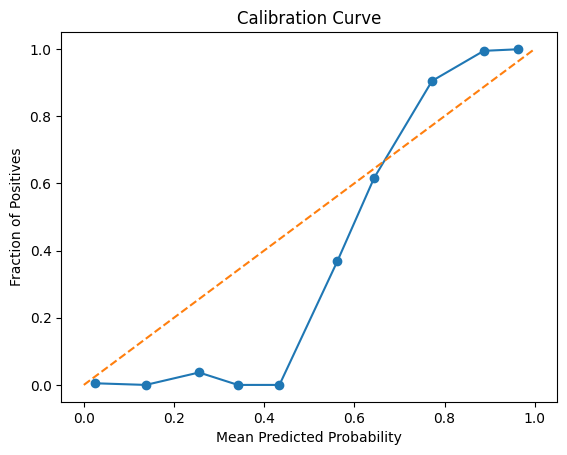

In [ ]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10, strategy='uniform')
plt.figure()
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.show()

## 8) Learning curve
Shows how performance scales with more training examples.

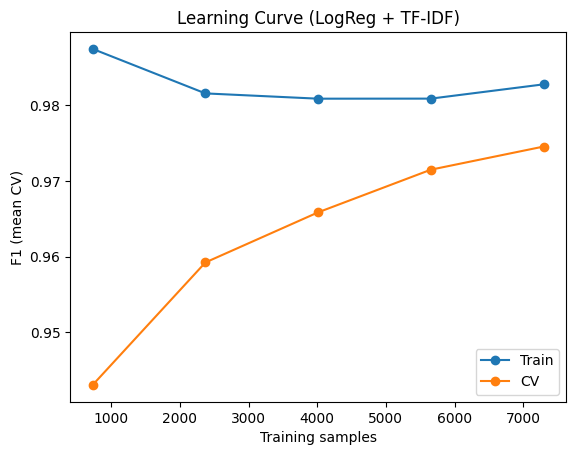

In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    clf, Xtr, y_train, cv=3, scoring='f1', n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
)
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o')
plt.plot(train_sizes, valid_scores.mean(axis=1), marker='o')
plt.xlabel('Training samples')
plt.ylabel('F1 (mean CV)')
plt.title('Learning Curve (LogReg + TF‑IDF)')
plt.legend(['Train', 'CV'])
plt.show()

## 9) Precision@K (triage usefulness)

In [ ]:
def precision_at_k(y_true, scores, k):
    import numpy as np
    idx = np.argsort(-scores)[:k]
    return y_true.to_numpy()[idx].sum() / k

for k in [10, 50, 100]:
    print(f'Precision@{k}:', precision_at_k(y_test, probs, k))

Precision@10: 1.0
Precision@50: 1.0
Precision@100: 1.0


### 10) Top weighted features (interpretation)

In [ ]:
feature_names = np.array(vectorizer.get_feature_names_out())
coefs = clf.coef_[0]
top_pos_idx = np.argsort(coefs)[-20:][::-1]
top_neg_idx = np.argsort(coefs)[:20]
print('Top + features (XSS‑indicative):')
for f, w in zip(feature_names[top_pos_idx], coefs[top_pos_idx]):
    print(f'{f:30s} {w:.3f}')
print('\nTop − features (benign‑indicative):')
for f, w in zip(feature_names[top_neg_idx], coefs[top_neg_idx]):
    print(f'{f:30s} {w:.3f}')

Top + features (XSS‑indicative):
draggable="true"               6.352
id=x                           4.108
<style>@keyframes              4.091
tabindex=1                     4.058
style="animation-name:x"       3.454
oncopy="alert(1)"              2.934
oncut="alert(1)"               2.909
onkeypress="alert(1)"          2.857
onkeydown="alert(1)"           2.839
autofocus>                     2.826
onbeforecut="alert(1)"         2.814
onkeyup="alert(1)"             2.789
onpaste="alert(1)"             2.779
onbeforecopy="alert(1)"        2.762
id=x tabindex=1                2.725
onbeforepaste="alert(1)"       2.722
<img                           2.570
<isindex                       1.837
<audio                         1.821
<marquee                       1.791

Top − features (benign‑indicative):
</a>                           -9.270
</li>                          -7.198
</span>                        -6.837
<li><a                         -6.044
</a> </li>                     -5.020


## 11) Robustness tests (simple obfuscations)

In [ ]:
import html, urllib.parse

def obfuscate(s):
    return [
        s,
        urllib.parse.quote(s),                 # URL-encode
        html.escape(s),                        # HTML-escape
        s.replace('<','< ').replace('>',' >'),# spacing
        s.replace('script','scr\u0131pt'),     # unicode homoglyph (i-dotless)
    ]

samples = ["<script>alert(1)</script>", '" onmouseover=alert(1) x="', "<img src=x onerror=alert(1)>"]
for s in samples:
    variants = obfuscate(s)
    Xv = vectorizer.transform(variants)
    scores = clf.predict_proba(Xv)[:,1]
    print('\nBase:', s)
    for v,sc in zip(variants, scores):
        print('  ', v[:80], ' -> ', round(sc,4))


Base: <script>alert(1)</script>
   <script>alert(1)</script>  ->  0.6435
   %3Cscript%3Ealert%281%29%3C/script%3E  ->  0.6435
   &lt;script&gt;alert(1)&lt;/script&gt;  ->  0.6435
   < script >alert(1)< /script >  ->  0.5405
   <scrıpt>alert(1)</scrıpt>  ->  0.6435

Base: " onmouseover=alert(1) x="
   " onmouseover=alert(1) x="  ->  0.5791
   %22%20onmouseover%3Dalert%281%29%20x%3D%22  ->  0.6435
   &quot; onmouseover=alert(1) x=&quot;  ->  0.6435
   " onmouseover=alert(1) x="  ->  0.5791
   " onmouseover=alert(1) x="  ->  0.5791

Base: <img src=x onerror=alert(1)>
   <img src=x onerror=alert(1)>  ->  0.8737
   %3Cimg%20src%3Dx%20onerror%3Dalert%281%29%3E  ->  0.6435
   &lt;img src=x onerror=alert(1)&gt;  ->  0.6435
   < img src=x onerror=alert(1) >  ->  0.6267
   <img src=x onerror=alert(1)>  ->  0.8737


## 12) Save artifacts & auto‑generate Markdown report

In [ ]:
import joblib, json
from pathlib import Path
out_dir = Path(ARTIFACT_DIR)
joblib.dump(vectorizer, out_dir / 'vectorizer.pkl')
joblib.dump(clf, out_dir / 'model.pkl')
pred_df = pd.DataFrame({'payload': X_test.values, 'label': y_test.values, 'score': probs, 'pred': pred})
pred_df.to_csv(out_dir / 'predictions.csv', index=False)
print('Saved to', out_dir.resolve())

# Build a small report from the computed metrics
p_at_10 = float(precision_at_k(y_test, probs, 10)) if len(y_test)>=10 else None
p_at_50 = float(precision_at_k(y_test, probs, 50)) if len(y_test)>=50 else None
p_at_100 = float(precision_at_k(y_test, probs, 100)) if len(y_test)>=100 else None

report = f"""
# XSS Detection — Baseline Report (AUTO)

## Summary
- Model: TF-IDF (1-3 ngrams, 20k) + LogisticRegression (class_weight='balanced')
- Test set size: {len(y_test)}
- PR AUC: {pr_auc:.4f}
- ROC AUC: {roc_auc:.4f}
- Precision@10: {p_at_10}
- Precision@50: {p_at_50}
- Precision@100: {p_at_100}

## Classification Report
```
{json.dumps(cls_rep, indent=2)}
```

## Notes
- This baseline focuses on payload text only.
- Use the robustness cell to gauge sensitivity to simple obfuscations.
- Consider adding request context and multi-vulnerability coverage.
"""

with open(out_dir / 'xss_project_report_AUTO.md', 'w', encoding='utf-8') as f:
    f.write(report)

out_dir / 'xss_project_report_AUTO.md'

Saved to /content/drive/MyDrive/V_Vasanth


PosixPath('/content/drive/MyDrive/V_Vasanth/xss_project_report_AUTO.md')

## (Optional) 13) Minimal Flask scoring API (commented)
Uncomment to export a tiny service that returns a probability for a given payload. (Run in a separate process/cell.)

In [ ]:
# %%bash
# cat > mini_api.py << 'PY'
# from flask import Flask, request, jsonify
# import joblib
# from pathlib import Path
#
# app = Flask(__name__)
# vec = joblib.load(Path('vasanth/vectorizer.pkl'))
# clf = joblib.load(Path('vasanth/model.pkl'))
#
# @app.route('/score', methods=['POST'])
# def score():
#     data = request.get_json(force=True)
#     payloads = data.get('payloads', [])
#     Xv = vec.transform(payloads)
#     probs = clf.predict_proba(Xv)[:,1].tolist()
#     return jsonify({'scores': probs})
#
# if __name__ == '__main__':
#     app.run(host='0.0.0.0', port=8080)
# PY
#
# echo 'Run with: python mini_api.py'